In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import rioxarray
import xarray as xr
import matplotlib.pyplot as plt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
import matplotlib.ticker as ticker
import cartopy.crs as ccrs
import random
import os

In [2]:
from fgwi import fgwi

In [3]:
folder = './Predicted PM2.5/'
files = os.listdir(folder)
data = xr.merge([xr.open_dataset(folder+file) for file in files])

C:\Users\user\AppData\Local\Temp\ipykernel_9280\2194005736.py:3: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'time' ('time',) The recommendation is to set join explicitly for this case.
  data = xr.merge([xr.open_dataset(folder+file) for file in files])
C:\Users\user\AppData\Local\Temp\ipykernel_9280\2194005736.py:3: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  data = xr.merge([xr.open_dataset(folder+file) for file in fi

In [4]:
t = data['time'][(data['time'].dt.year > 2020) & (data['time'].dt.year < 2025)]

In [5]:
data = data.sel(time=pd.to_datetime(t.values))

In [6]:
data = fgwi(data, 5)

In [7]:
data.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)
data.rio.write_crs("epsg:4326", inplace=True)

<xarray.Dataset> Size: 7GB
Dimensions:      (time: 1461, latitude: 604, longitude: 955)
Coordinates:
  * time         (time) datetime64[ns] 12kB 2021-01-01 2021-01-02 ... 2024-12-31
  * latitude     (latitude) float64 5kB 31.0 31.0 31.0 31.0 ... 32.2 32.2 32.2
  * longitude    (longitude) float64 8kB 35.5 35.5 35.5 35.5 ... 37.4 37.4 37.4
    spatial_ref  int64 8B 0
Data variables:
    Pred_PM2.5   (time, latitude, longitude) float64 7GB 42.44 42.44 ... 30.12

In [8]:
gdf = gpd.read_file('./Amman shp/Amman.shp').set_crs('epsg:4326')

In [9]:
y_data = data.groupby(data['time'].dt.year).mean()

In [10]:
all_m_data = data.groupby(data['time'].dt.month).mean()

In [11]:
y_data = y_data.rio.clip(gdf.geometry, gdf.crs)

In [12]:
all_m_data = all_m_data.rio.clip(gdf.geometry, gdf.crs)

In [13]:
for i in range(len(y_data['Pred_PM2.5'].values)):
    y = y_data['year'].values[i]
    mean = np.round(np.nanmean(y_data['Pred_PM2.5'].values[i]), 2)

    print(f'{y} average: {mean:.2f}')

2021 average: 26.62
2022 average: 28.58
2023 average: 30.63
2024 average: 28.60


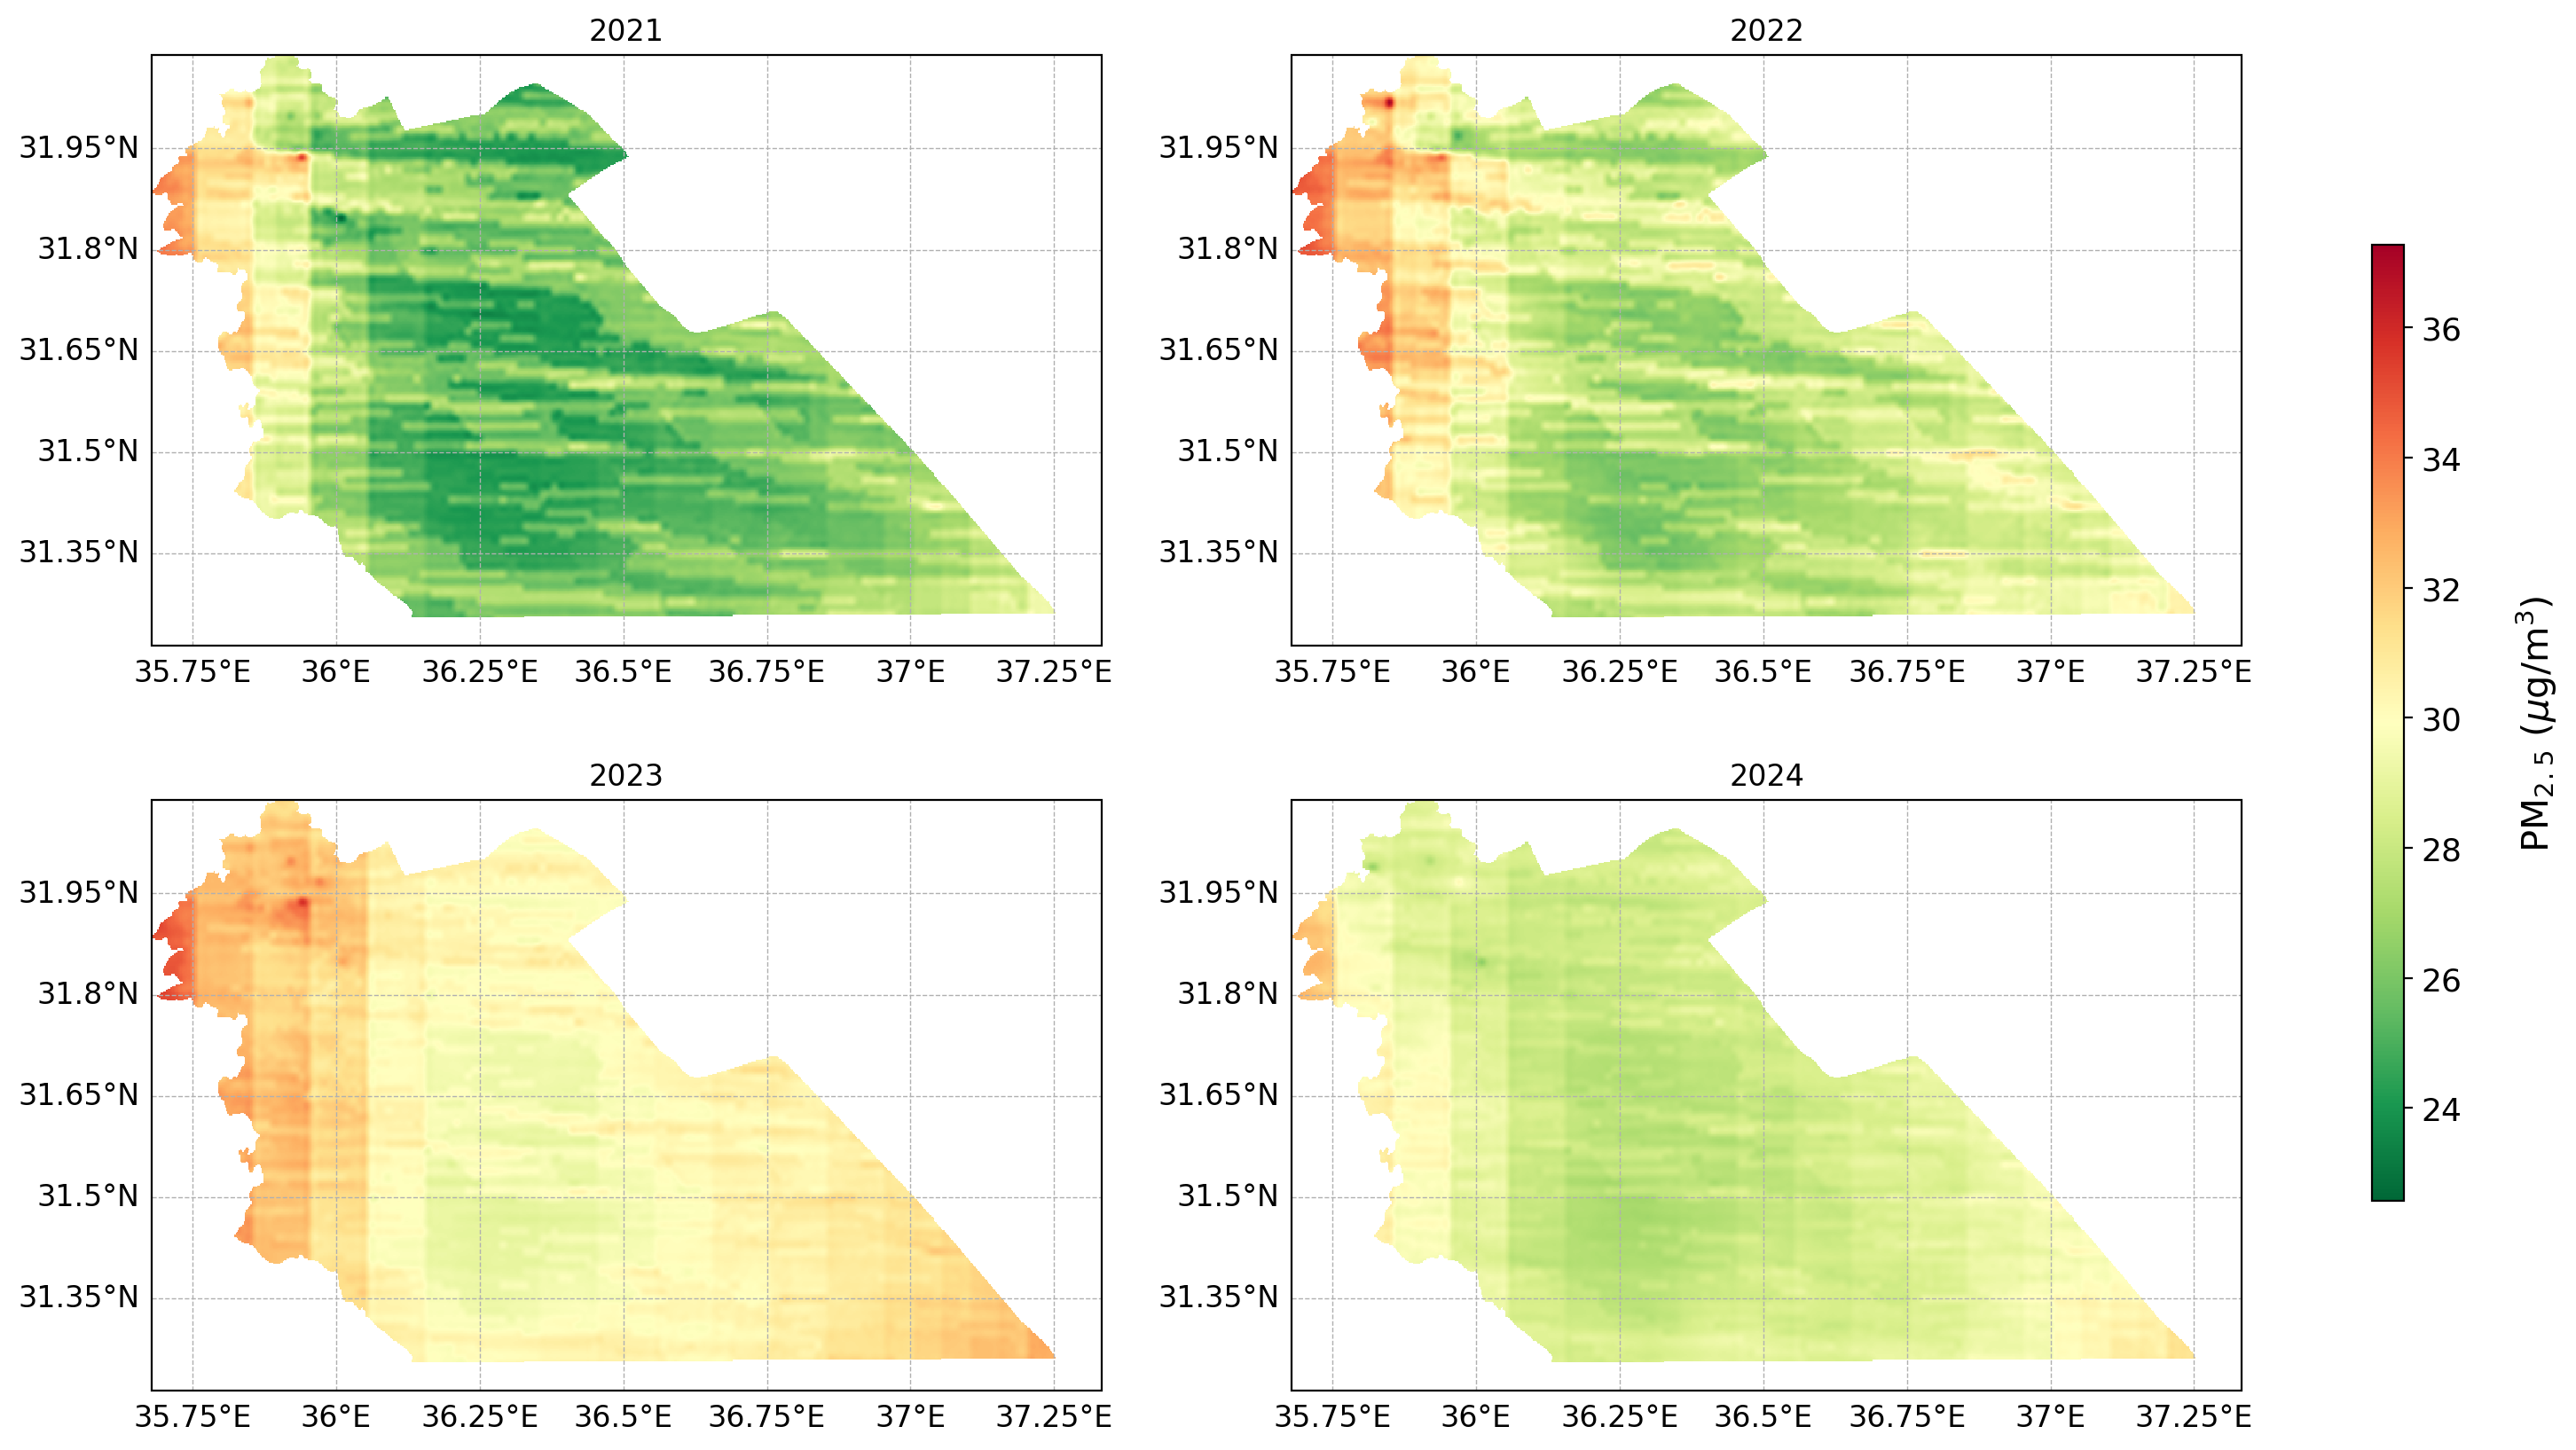

In [35]:
# Create figure and GeoAxes
fig, axs = plt.subplots(2, 2, subplot_kw={'projection': ccrs.PlateCarree()}, sharex=True, sharey=True, figsize=(19, 10), dpi=200)

j, k = 0, 0
vmin = y_data['Pred_PM2.5'].min().values
vmax = y_data['Pred_PM2.5'].max().values

for i in range(4):
    variable_name = 'Pred_PM2.5'
    data_at_time = y_data[variable_name].isel(year=i)

    # Convert subplot to Cartopy GeoAxes
    #axs[j, k] = plt.subplot(2, 2, i + 1, projection=ccrs.PlateCarree())

    # Plot data
    im = data_at_time.plot(cmap='RdYlGn_r', ax=axs[j, k], vmin=vmin, vmax=vmax, add_colorbar=False)
    gdf.plot(ax=axs[j, k], edgecolor='red', facecolor='none', linewidth=0)

    # Set longitude & latitude gridline format
    gridliner = axs[j, k].gridlines(draw_labels=True, linestyle="--", linewidth=0.5)
    gridliner.xformatter = LONGITUDE_FORMATTER
    gridliner.yformatter = LATITUDE_FORMATTER
    #gridliner.xlocator = mticker.FixedLocator(range(-180, 181, 10))  # Adjust longitude step
    #gridliner.ylocator = mticker.FixedLocator(range(-90, 91, 10))    # Adjust latitude step
    gridliner.right_labels = False  # Remove right labels
    gridliner.top_labels = False    # Remove top labels
    gridliner.xlabel_style = {'size': 12}
    gridliner.ylabel_style = {'size': 12}


    # Set x and y labels
    # Set x and y labels for each subplot
    if j == 1:
        axs[j, k].set_xlabel('\nLongitude', size=11)
    else:
        axs[j, k].set_xlabel('')
    
    if k == 0:
        axs[j, k].set_ylabel('Latitude\n', size=11)
        

    else:
        axs[j, k].set_ylabel(' \n \n ')
    
    # Set title for each subplot (e.g., based on year)
    axs[j, k].set_title(f'{y_data["year"].values[i]}')
    #axs[j, k].grid(True)

    k += 1
    if i == 1:
        k = 0
        j += 1

#plt.tight_layout()
cbar = fig.colorbar(im, ax=axs, location='right', shrink=0.7, aspect=30)
cbar.ax.tick_params(labelsize=13)
cbar.set_label('\nPM$_2$$_.$$_5$ ($\mu$g/m$^3$)', size=15)

plt.show()

In [15]:
month_names = [
    "January",
    "February",
    "March",
    "April",
    "May",
    "June",
    "July",
    "August",
    "September",
    "October",
    "November",
    "December"
]

In [16]:
for i in range(len(all_m_data['Pred_PM2.5'].values)):
    #y = y_data['month'].values[i]
    mean = np.round(np.nanmean(all_m_data['Pred_PM2.5'].values[i]), 2)

    print(f'{month_names[i]} average: {mean:.2f}')

January average: 29.77
February average: 28.75
March average: 27.15
April average: 33.76
May average: 27.54
June average: 24.79
July average: 24.81
August average: 26.73
September average: 26.61
October average: 30.05
November average: 31.85
December average: 31.60


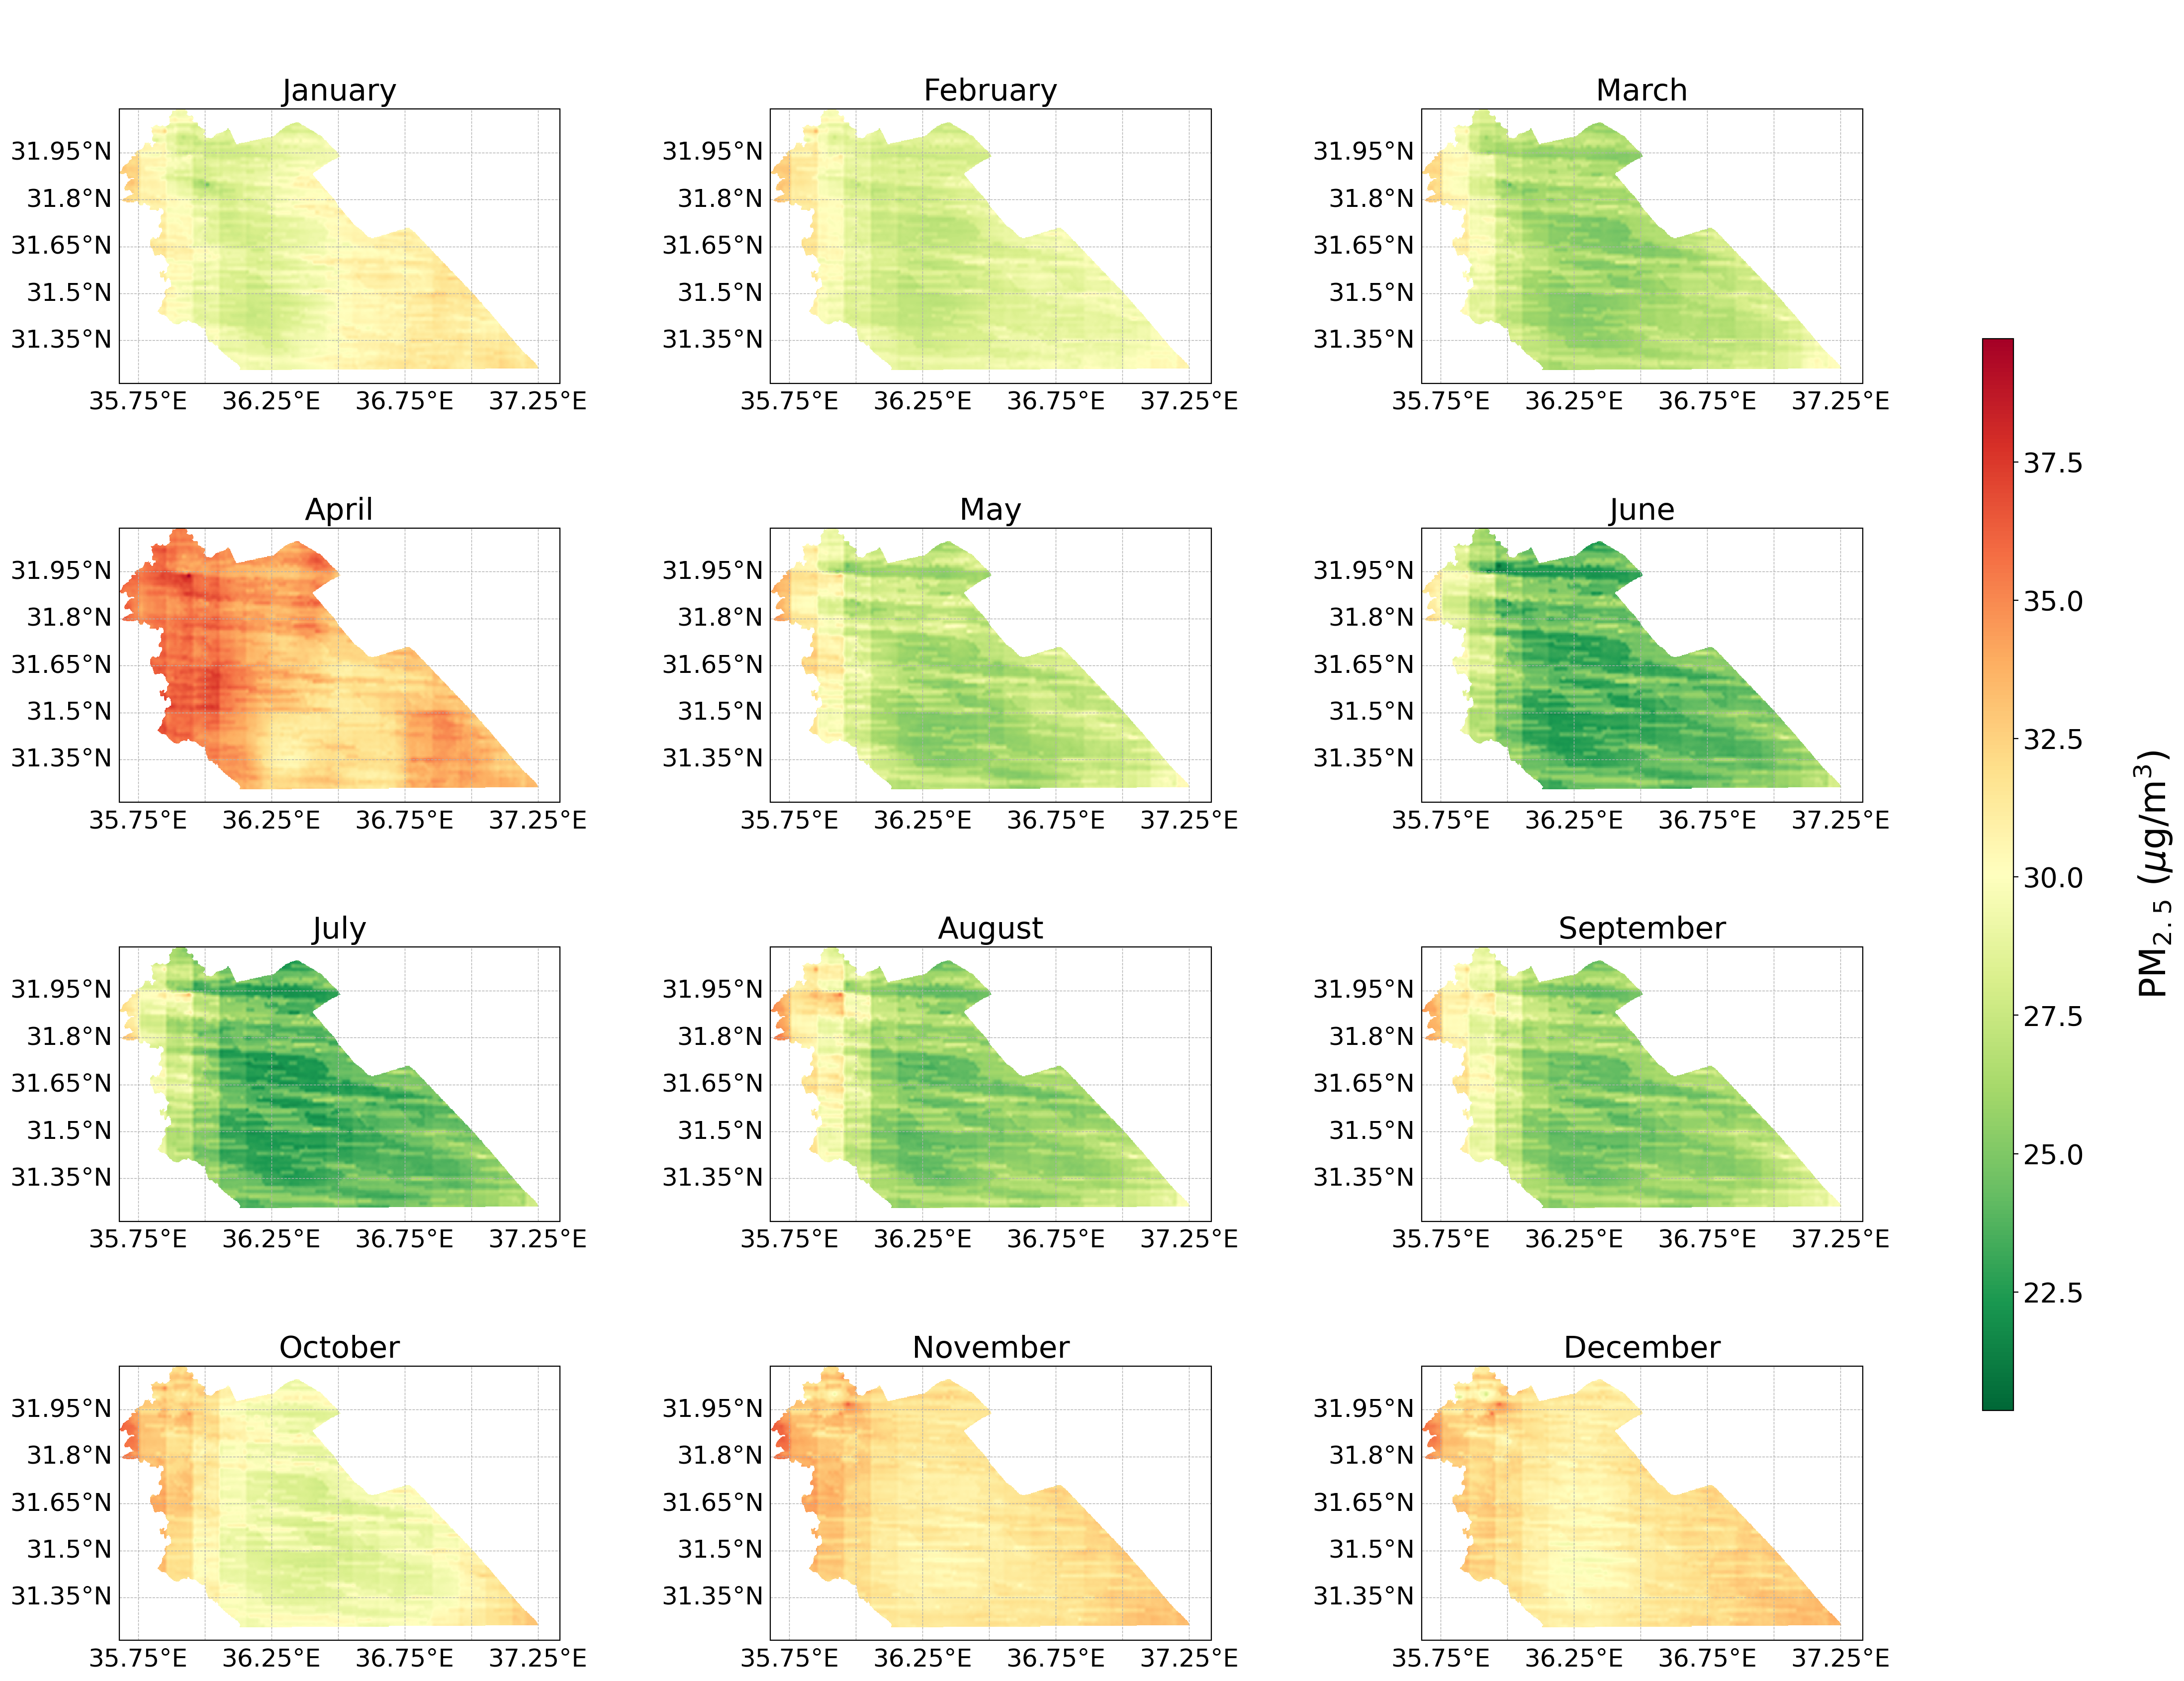

In [36]:
fig, axs = plt.subplots(4, 3, subplot_kw={'projection': ccrs.PlateCarree()}, sharex=True, sharey=True, figsize=(25, 17), dpi=200)
j = 0
k = 0

vmin = all_m_data['Pred_PM2.5'].min().values
vmax = all_m_data['Pred_PM2.5'].max().values



for i in range(12):
    variable_name = 'Pred_PM2.5'
    #time_step = i
    data_at_time = all_m_data[variable_name].isel(month=i)
    #axs[0, 0] = axs[0, 0].gca()
    im = data_at_time.plot(cmap='RdYlGn_r', ax=axs[j, k], vmin=vmin, vmax=vmax, add_colorbar=False)
    #if k == 0:
      #cbar = fig.colorbar(im, ax=axs[j, k], location='right', shrink=0.96)
    #if k == 1:
      #cbar.set_label('PM2.5 ($\mu$g/m$^3$)\n')
    gdf.plot(ax=axs[j, k], edgecolor='red', facecolor='none', linewidth=0)

    # Set longitude & latitude gridline format
    gridliner = axs[j, k].gridlines(draw_labels=True, linestyle="--", linewidth=0.5)
    gridliner.xformatter = LONGITUDE_FORMATTER
    gridliner.yformatter = LATITUDE_FORMATTER
    #gridliner.xlocator = mticker.FixedLocator(range(-180, 181, 10))  # Adjust longitude step
    #gridliner.ylocator = mticker.FixedLocator(range(-90, 91, 10))    # Adjust latitude step
    gridliner.right_labels = False  # Remove right labels
    gridliner.top_labels = False    # Remove top labels
    gridliner.xlabel_style = {'size': 18}
    gridliner.ylabel_style = {'size': 18}
    
    # Set x and y labels for each subplot
    if j == 3:
        axs[j, k].set_xlabel('\nLongitude', size=12)
    else:
        axs[j, k].set_xlabel('')
    
    if k == 0:
        axs[j, k].set_ylabel('Latitude\n', size=12)
    else:
        axs[j, k].set_ylabel(' \n ')
    
    # Set title for each subplot (e.g., based on year)
    axs[j, k].set_title(f'\n\n{month_names[i]}', size=22)
    #axs[j, k].grid(True)

    k += 1
    if (i+1) % 3 == 0:
        k = 0
        j += 1

    
plt.tight_layout()
cbar = fig.colorbar(im, ax=axs, location='right', shrink=0.7, aspect=35)
cbar.ax.tick_params(labelsize=20)
cbar.set_label('\nPM$_2$$_.$$_5$ ($\mu$g/m$^3$)', size=26)
plt.show()
    

In [15]:
import os
import geopandas as gpd

In [16]:
folder = './Governates shapefiles/'
files = sorted(os.listdir(folder))
govshp = []
for i in range(len(files)):
    if files[i].endswith('.shp') == True:
        govshp.append(files[i])

In [17]:
govs = [gpd.read_file(folder + file, crs="EPSG:4326") for file in govshp]

In [18]:
yrs_df = []
for i in range(len(govs)):
    c = y_data.rio.clip(govs[i].geometry, govs[i].crs)
    yrs_df.append(c.to_dataframe().reset_index().groupby('year')[list(y_data.data_vars.keys())[0]].mean().reset_index())

In [19]:
yrs_df[0]

year  Pred_PM2.5
0  2021   24.935221
1  2022   28.191273
2  2023   26.607031
3  2024   25.210144

In [20]:
gov_names = []
for gov in govshp:
    gov_names.append(gov[:-4])

In [21]:
gov_names[0]

'Ajlun'

In [22]:
tab = pd.DataFrame(index=yrs_df[0]['year'])
for i in range(len(gov_names)):
    tab[gov_names[i]] = yrs_df[i].set_index('year')

In [23]:
tab.astype('float64').round(2).to_excel('Table 4 Gov_Yr_avg.xlsx')

Months DataFrame

In [24]:
all_m_data

<xarray.Dataset>
Dimensions:      (latitude: 84, longitude: 86, month: 12)
Coordinates:
  * latitude     (latitude) float64 29.2 29.25 29.3 29.35 ... 33.25 33.3 33.35
  * longitude    (longitude) float64 35.0 35.05 35.1 35.15 ... 39.15 39.2 39.25
  * month        (month) int32 1 2 3 4 5 6 7 8 9 10 11 12
    spatial_ref  int32 0
Data variables:
    Pred_PM2.5   (month, latitude, longitude) float32 nan nan nan ... nan nan

In [25]:
mnth_df = []
for i in range(len(govs)):
    c = all_m_data.rio.clip(govs[i].geometry, govs[i].crs)
    mnth_df.append(c.to_dataframe().reset_index().groupby('month')[list(y_data.data_vars.keys())[0]].mean().reset_index())

In [26]:
tab5 = pd.DataFrame(index=mnth_df[0]['month'])
for i in range(len(gov_names)):
    tab5[gov_names[i]] = mnth_df[i].set_index('month')

In [27]:
tab5.index = month_names

In [28]:
tab5.astype('float64').round(2).to_excel('Table 5 Gov_mnth_avg.xlsx')

In [29]:
tab5 = tab5.astype('float64').round(2)

In [30]:
random.seed(2010)

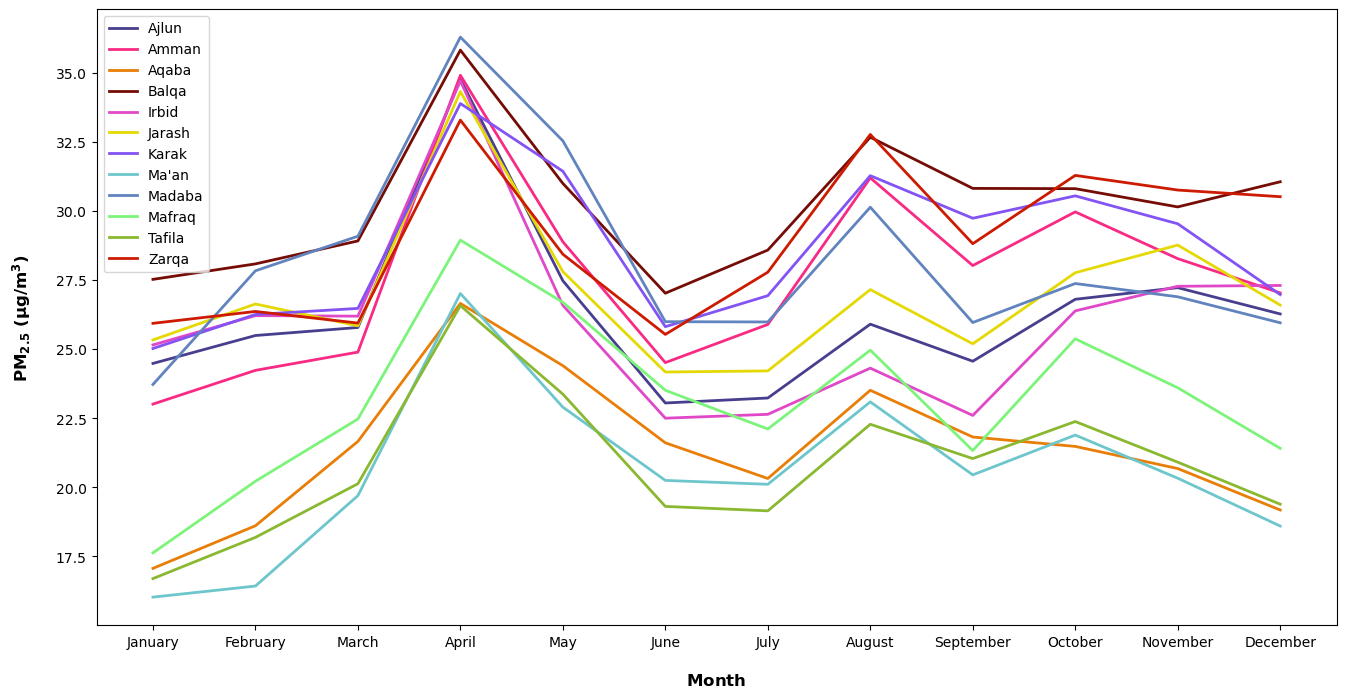

In [31]:
plt.figure(figsize=(16,8), dpi=100)
#random.seed(2010)
for col in tab5.columns:
    color = '#{:06x}'.format(random.randint(0, 256**3))
    plt.plot(tab5.index, tab5[col], label=col, c=color, linewidth=2)

plt.xlabel('\n'+r'$\mathbf{Month}$', size=12)
plt.ylabel(r"$\mathbf{PM_{2.5}\ (\mu g/m^3)}$" + '\n', size=12)
plt.legend()
plt.show()